## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
analysis_params = {
  "model_type": "lca",
  "model_name": "lca_mnist",
  "version": "0.0",
  "save_info": "analysis",
  "overwrite_analysis": False}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"+analysis_params["model_name"])

In [4]:
analyzer = ap.get_analyzer(analysis_params)
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.load_analysis(save_info=analysis_params["save_info"])

In [5]:
if hasattr(analyzer, "ot_grating_responses"):
  ot_bf_indices = analyzer.ot_grating_responses["neuron_indices"]
  ot_contrasts = analyzer.ot_grating_responses["contrasts"]
  ot_phases = analyzer.ot_grating_responses["phases"]
  ot_orientations = analyzer.ot_grating_responses["orientations"]
  ot_best_phases = analyzer.ot_grating_responses["best_phases"]
  ot_mean_activations = analyzer.ot_grating_responses["mean_responses"]

if hasattr(analyzer, "co_grating_responses"):
  co_bf_indices = analyzer.co_grating_responses["neuron_indices"]
  co_contrasts = analyzer.co_grating_responses["contrasts"]
  co_phases = analyzer.co_grating_responses["phases"]
  co_base_orientations = analyzer.co_grating_responses["base_orientations"]
  co_mask_orientations = analyzer.co_grating_responses["mask_orientations"]
  co_base_mean_responses = analyzer.co_grating_responses["base_mean_responses"]
  co_test_mean_responses = analyzer.co_grating_responses["test_mean_responses"]

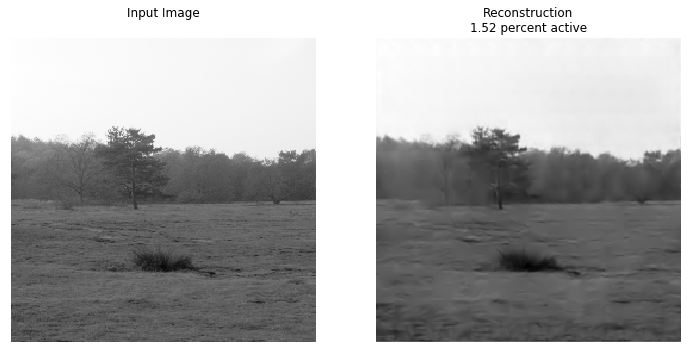

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0] = pf.clear_axis(ax[0])
ax[0].imshow(np.squeeze(analyzer.full_image), cmap="Greys_r")
ax[0].set_title("Input Image\n")
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(np.squeeze(analyzer.full_recon), cmap="Greys_r")
percent_active = "{:.2f}".format(analyzer.recon_frac_act*100)
ax[1].set_title("Reconstruction\n"+percent_active+" percent active")
plt.show()
fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_image_recon.png", transparent=True,
  bbox_inches="tight")

In [6]:
data = ds.get_data(analyzer.model_params)
data = analyzer.model.preprocess_dataset(data, analyzer.model_params)
data = analyzer.model.reshape_dataset(data, analyzer.model_params)

#analyzer.model_params["data_shape"] = list(data["train"].shape[1:])
#analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
#analyzer.model_params["input_shape"] = [
#  data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]

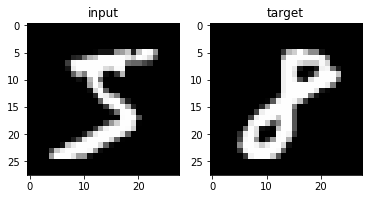

In [23]:
input_image = data["train"].images[analyzer.adversarial_input_id,...][None,...].astype(np.float32)
target_image = data["train"].images[analyzer.adversarial_target_id,...][None,...].astype(np.float32)
fig, axes = plt.subplots(1,2)
axes[0].imshow(np.squeeze(input_image).reshape(int(np.sqrt(analyzer.model.num_pixels)), int(np.sqrt(analyzer.model.num_pixels))), cmap="Greys_r")
axes[0].set_title("input")
axes[1].imshow(np.squeeze(target_image).reshape(int(np.sqrt(analyzer.model.num_pixels)), int(np.sqrt(analyzer.model.num_pixels))), cmap="Greys_r")
axes[1].set_title("target")
plt.show()
fig.savefig(analyzer.analysis_out_dir+"/vis/adversarial_input_target.png")

In [27]:
if not os.path.exists(analyzer.analysis_out_dir+"/vis/adversarial_recons/"):
  os.makedirs(analyzer.analysis_out_dir+"/vis/adversarial_recons/")
if not os.path.exists(analyzer.analysis_out_dir+"/vis/adversarial_stims/"):
  os.makedirs(analyzer.analysis_out_dir+"/vis/adversarial_stims/")
for recon in self.adversarial_recons:
  pf.plot_matrix(recon.reshape(int(np.sqrt(analyzer.model.num_pixels)),int(np.sqrt(analyzer.model.num_pixels))), title="step_"+str(step),
    save_filename=analyzer.analysis_out_dir+"/vis/adversarial_recons/recon_step_"+str(step)+".png")
for stim in self.adversarial_images:
  pf.plot_matrix(stim.reshape(int(np.sqrt(analyzer.model.num_pixels)),int(np.sqrt(analyzer.model.num_pixels))), title="step_"+str(step),
    save_filename=analyzer.analysis_out_dir+"/vis/adversarial_stims/stim_step_"+str(step)+".png")

FileExistsError: [Errno 17] File exists: '/home/dpaiton/Work/Projects/lca_mnist/analysis/0.0//vis/adversarial_recons/'

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_mnist/checkpoints/lca_mnist_v0.0_weights-100000


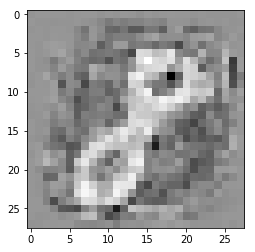

In [28]:
eps = 0.01
num_steps = 250
losses = []
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config, graph=analyzer.model.graph) as sess:
  feed_dict = analyzer.model.get_feed_dict(input_image)
  sess.run(analyzer.model.init_op, feed_dict)
  analyzer.model.load_weights(sess, analyzer.cp_loc)
  orig = tf.constant(input_image, dtype=tf.float32, name="original_image")
  target = tf.constant(target_image, dtype=tf.float32, name="target_image")
  reduc_dim = list(range(1, len(analyzer.model.a.shape))) # Want to avg over batch, sum over the rest
  target_recon_loss = tf.reduce_mean(0.5 *
    tf.reduce_sum(tf.square(tf.subtract(target, analyzer.model.compute_recon(analyzer.model.a))),
    axis=reduc_dim), name="target_recon_loss")
  orig_recon_loss = tf.reduce_mean(0.5 *
    tf.reduce_sum(tf.square(tf.subtract(orig, analyzer.model.compute_recon(analyzer.model.a))),
    axis=reduc_dim), name="target_recon_loss")
  losses.append((sess.run(orig_recon_loss, feed_dict), sess.run(target_recon_loss, feed_dict)))
  dx = tf.gradients(target_recon_loss, analyzer.model.x)[0]
  new_feed_dict = analyzer.model.get_feed_dict(input_image)
  for step in range(num_steps):
    new_img = sess.run(tf.add(analyzer.model.x, tf.multiply(-eps, tf.sign(dx))), new_feed_dict)
    new_feed_dict = analyzer.model.get_feed_dict(new_img)
    recon = sess.run(analyzer.model.x_, new_feed_dict)
    pf.plot_matrix(recon.reshape(int(np.sqrt(analyzer.model.num_pixels)),int(np.sqrt(analyzer.model.num_pixels))), title="step_"+str(step),
      save_filename=analyzer.analysis_out_dir+"/vis/adversarial_recons/recon_step_"+str(step)+".png")
    pf.plot_matrix(new_img.reshape(int(np.sqrt(analyzer.model.num_pixels)),int(np.sqrt(analyzer.model.num_pixels))), title="step_"+str(step),
      save_filename=analyzer.analysis_out_dir+"/vis/adversarial_stims/stim_step_"+str(step)+".png")
    losses.append((sess.run(orig_recon_loss, new_feed_dict), sess.run(target_recon_loss, new_feed_dict)))

plt.imshow(new_img.reshape(int(np.sqrt(analyzer.model.num_pixels)),int(np.sqrt(analyzer.model.num_pixels))), cmap="Greys_r")
plt.show()

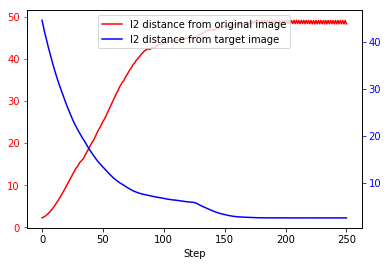

In [22]:
fig, ax1 = plt.subplots()
line1 = ax1.plot([loss[0] for loss in analyzer.adversarial_losses], 'r', label="l2 distance from original image")
ax1.tick_params('y', colors='r')
ax1.set_xlabel("Step")
ax2 = ax1.twinx()
line2 = ax2.plot([loss[1] for loss in analyzer.adversarial_losses], 'b', label="l2 distance from target image")
ax2.tick_params('y', colors='b')
lines = line1+line2
line_labels = [l.get_label() for l in lines]
ax1.legend(lines, line_labels, loc=9)
fig.savefig(analyzer.analysis_out_dir+"/vis/adversarial_losses.png")
plt.show()

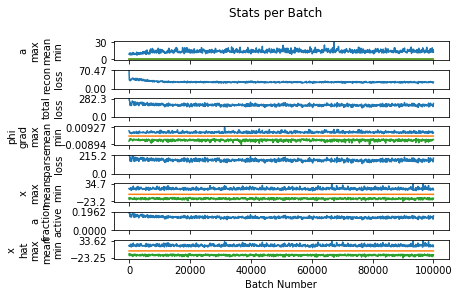

In [7]:
#keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"]
#labels=["activity", "recon loss", "sparse loss", "total loss"]
stats_fig = pf.plot_stats(analyzer.run_stats)#, keys=keys, labels=labels)
stats_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_train_stats.png")

In [8]:
atas_fig = pf.plot_data_tiled(analyzer.atas.T, normalize=False, title="Activity triggered averages on image data")
atas_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_img_atas.png")

AttributeError: 'SUBSPACE_LCA_Analyzer' object has no attribute 'atas'

In [11]:
num_noise_images = analyzer.num_noise_images
if hasattr(analyzer, "noise_activity"):
  noise_activity = analyzer.noise_activity
  noise_atas = analyzer.noise_atas
  noise_atcs = analyzer.noise_atcs
  noise_atas_fig = pf.plot_data_tiled(noise_atas.T, normalize=False, title="Activity triggered averages on standard normal noise data")
  noise_atas_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_noise_atas.png")
  neuron_idx=0
  evals, evecs = np.linalg.eigh(noise_atcs[neuron_idx,...]) 
  top_indices = np.argsort(evals)[::-1]
  fig = pf.plot_weights(evecs.T.reshape(256,16,16)[top_indices,:,:])
  fig2 = pf.plot_eigenvalues(evals[::-1], ylim=[np.min(evals), np.max(evals)])

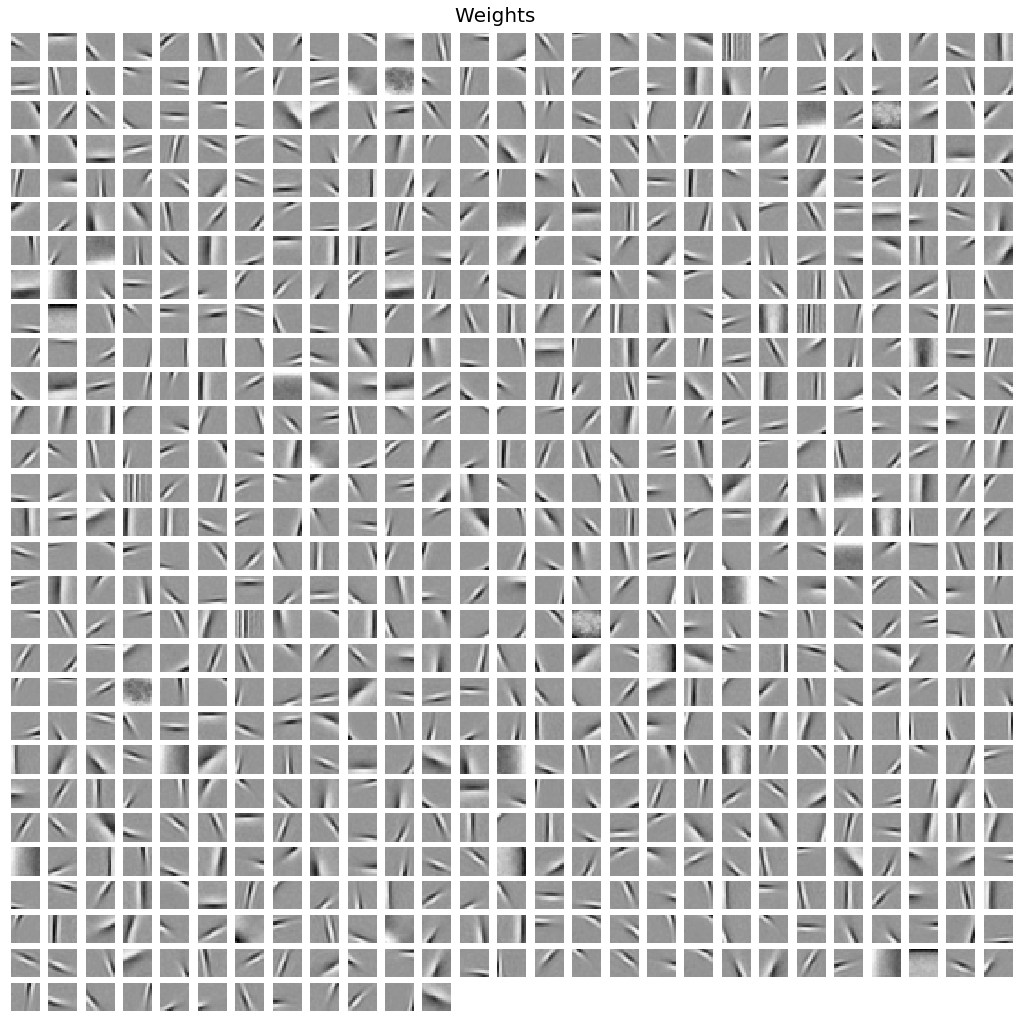

In [10]:
weight_shape = [analyzer.bf_stats["num_outputs"], analyzer.bf_stats["patch_edge_size"], analyzer.bf_stats["patch_edge_size"]]
dict_fig = pf.plot_weights(analyzer.evals["weights/phi:0"].T.reshape(weight_shape), title="Weights")
dict_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_dict.png", transparent=True,
  bbox_inches="tight")

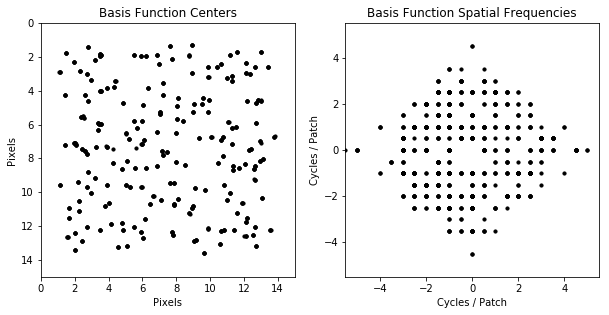

In [12]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
fig.savefig(analyzer.analysis_out_dir+"/vis/fig_location_frequency_centers.png")

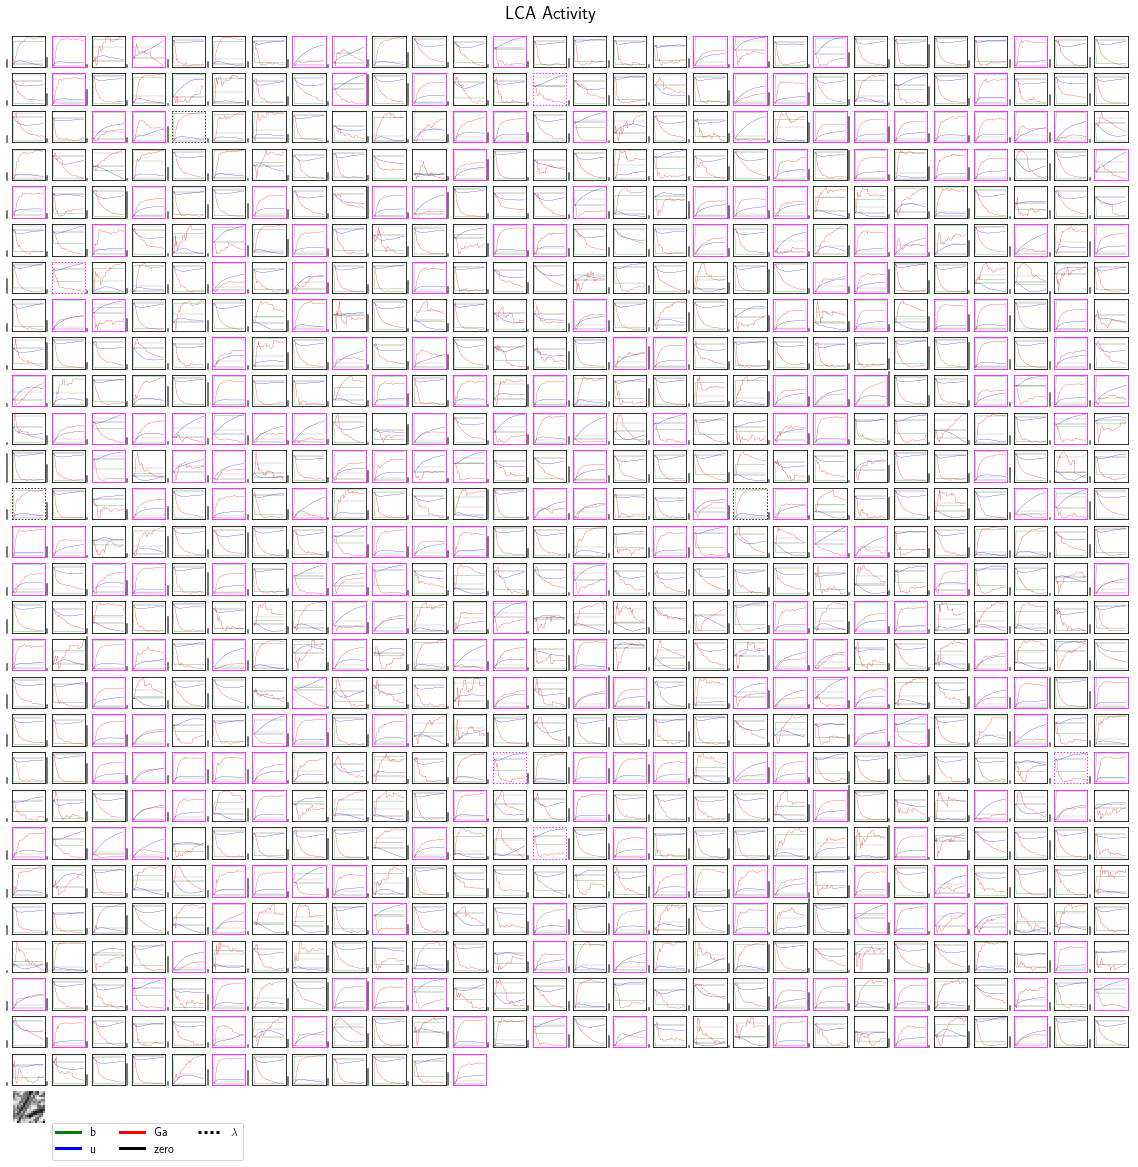

In [7]:
act_indicator_threshold = 0.75
inf_trace_fig = pf.plot_inference_traces(analyzer.inference_stats, analyzer.model_schedule[0]["sparse_mult"],
  act_indicator_threshold=act_indicator_threshold)
inf_trace_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_inference_traces_dots"+str(act_indicator_threshold)+".pdf")

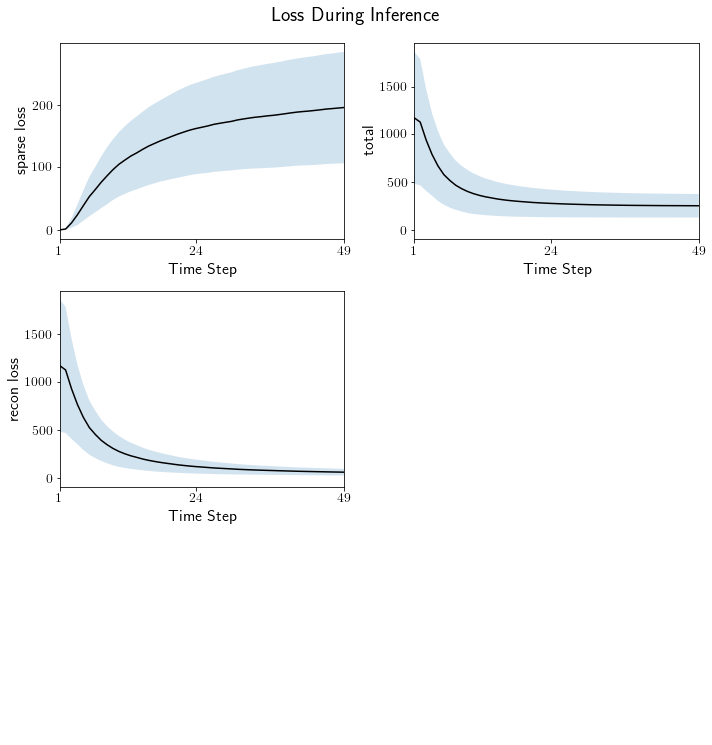

In [66]:
inf_stats_fig = pf.plot_inference_stats(analyzer.inference_stats, title="Loss During Inference")
inf_stats_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_inference_loss.png")

In [ ]:
#rectified_resp = analyzer.ot_grating_responses["rectified_responses"].reshape(2*analyzer.model_params["num_neurons"],
#  len(ot_contrasts), len(ot_orientations))
#ot_fig = pf.plot_contrast_orientation_tuning(ot_bf_indices, ot_contrasts, ot_orientations, rectified_resp)
ot_fig = pf.plot_contrast_orientation_tuning(ot_bf_indices, ot_contrasts, ot_orientations, ot_mean_activations)
ot_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_orientation_tuning.pdf")

In [ ]:
#cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, analyzer.co_grating_responses["test_mean_responses"])
cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, co_test_mean_responses)
cross_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_cross_orientation_tuning.pdf")

In [ ]:
cross_contrast_fig = pf.plot_plaid_contrast_tuning(co_bf_indices, co_contrasts, co_contrasts, co_base_orientations,
  co_mask_orientations, co_test_mean_responses)
cross_contrast_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params["model_name"]+"_cross_contrast_orientation_tuning.pdf")

In [ ]:
#grating = lambda bf_idx,orientation,phase,contrast:dp.generate_grating(
#  *dp.get_grating_params(bf_stats=analyzer.bf_stats, bf_idx=bf_idx, orientation=orientation,
#  phase=phase, contrast=contrast, diameter=-1)).reshape(16,16)
#
#bf_idx = 29
#bf = analyzer.evals["weights/phi:0"].T[co_bf_indices[bf_idx],:].reshape(16,16)
#base_stim = grating(co_bf_indices[bf_idx], co_base_orientations[bf_idx], co_phases[0], 0.5)
#mask_stim = grating(co_bf_indices[bf_idx], orthogonal_orientations[bf_idx], co_phases[5], 0.5)
#test_stim = base_stim + mask_stim
#
#all_min = np.min(np.stack([base_stim, mask_stim, test_stim]))
#all_max = np.max(np.stack([base_stim, mask_stim, test_stim]))
#
#fig, axes = plt.subplots(4)
#axes[0] = pf.clear_axis(axes[0])
#axes[1] = pf.clear_axis(axes[1])
#axes[2] = pf.clear_axis(axes[2])
#axes[3] = pf.clear_axis(axes[3])
#axes[0].imshow(bf, cmap="Greys_r")
#axes[1].imshow(base_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[2].imshow(mask_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[3].imshow(test_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#plt.show()
#fig.savefig("/home/dpaiton/tmp_figs/"+analysis_params["model_name"]+"_ex_cross_stim.png")

In [ ]:
#constructed_bfs = np.zeros_like(analyzer.evals["weights/phi:0"].T)
#for bf_idx in range(constructed_bfs.shape[0]):
#  params = dp.get_grating_params(analyzer.bf_stats, bf_idx)
#  grating = dp.generate_grating(*params)
#  constructed_bfs[bf_idx,...] = grating.reshape(256)
#fig = pf.plot_data_tiled(constructed_bfs)

### compute iso_response_contrast curves

In [ ]:
outputs = analyzer.iso_response_contrasts(analyzer.bf_stats, base_contrast=0.5, contrast_resolution=0.01,
  closeness=0.01, num_alt_orientations=4, orientations=np.linspace(0.0, np.pi, 16),
  phases = np.linspace(-np.pi, np.pi, 12), neuron_indices=[52,53,54], diameter=-1,
  scale=analyzer.analysis_params["input_scale"])

In [ ]:
outputs["iso_response_parameters"][0]